In [43]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import random

import gym
import matplotlib.pyplot as plt

In [3]:
NUM_RUNS = 10
EPSILON = 1      # placeholder value - you should implement your own exploration schedule

In [4]:
runs_results = []

env = gym.make('CartPole-v1')
for run in range(NUM_RUNS):
    print(f"Starting run {run+1} of {NUM_RUNS}")
    policy_net = DQN([4,2]) 
    target_net = DQN([4,2])
    update_target(target_net, policy_net)
    target_net.eval()

    optimizer = optim.SGD(policy_net.parameters(), lr=1.)
    memory = ReplayBuffer(1)

    steps_done = 0

    episode_durations = []

    for i_episode in range(300):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", 300)

        observation, info = env.reset()
        state = torch.tensor(observation).float()

        done = False
        terminated = False
        t = 0
        while not (done or terminated):

            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)

            observation, reward, done, terminated, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()

            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < 1:
                transitions = memory.sample(1)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
            
            if done or terminated:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % 1 == 0: 
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
print('Complete')

Starting run 1 of 10


/Users/elijahahmad/Downloads/Reinforcement Learning CW2/reinforcement-learning/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episod

In [ ]:
def run_individual(individual):
    # tweak this to run for the variation in hyperparameters
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(individual["num_runs"]):
        print(f"Starting run {run+1} of {individual['num_runs']}")
        policy_net = DQN(individual["network_architecture"]) 
        target_net = DQN(individual["network_architecture"])
        update_target(target_net, policy_net)
        target_net.eval()
    
        optimizer = optim.SGD(policy_net.parameters(), lr=individual["learning_rate"])
        memory = ReplayBuffer(individual["replay_buffer_size"])
    
        episode_durations = []
        
        epsilon_start = 1.0
        epsilon_end = 0.01
        epsilon_decay = individual["epsilon_decay"]
        epsilon = epsilon_start
    
        for i_episode in range(300):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)
    
            # Epsilon Decay
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                math.exp(-1. * i_episode / epsilon_decay)
    
            observation, info = env.reset()
            state = torch.tensor(observation).float()
    
            done = False
            terminated = False
            t = 0
            while not (done or terminated):
    
                # Select and perform an action
                action = epsilon_greedy(epsilon, policy_net, state)
    
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()
    
                memory.push([state, action, next_state, reward, torch.tensor([done])])
    
                # Move to the next state
                state = next_state
    
                # Perform one step of the optimization (on the policy network)
                if len(memory.buffer) >= individual["batch_size"]:
                    transitions = memory.sample(individual["batch_size"])
                    state_batch, action_batch, next_state_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
    
                    
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
    
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()
                
                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
                
            # Update the target network, copying all weights and biases in DQN
            if i_episode % individual["update_frequency"] == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results
    
def plot_chart(runs_results, filename):
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)
    
    plt.plot(torch.arange(300), means)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
    plt.savefig(filename)
    plt.show()
    plt.close()
    
hyper_parameter_space = {
    "num_runs": [10],
    "epsilon_decay": [0.01, 0.05, 0.1, 0.2],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "replay_buffer_size": [10000, 20000],
    "batch_size": [32, 64, 128, 256],
    "update_frequency": [5, 10, 50, 100],
    "loss_function": ["MSE"],
    "network_architecture": [[4, 64, 64, 2], [4, 128, 128, 2], [4, 256, 256, 2], [4, 128, 256, 128, 2]]
}

loss_function = "MSE"
# Example pseudocode to iterate over all combinations
for num_runs in hyper_parameter_space["num_runs"]:
        for network_architecture in hyper_parameter_space["network_architecture"]:
            for batch_size in hyper_parameter_space["batch_size"]:
                for update_frequency in hyper_parameter_space["update_frequency"]:
                    for replay_buffer_size in hyper_parameter_space["replay_buffer_size"]:
                        for epsilon_decay in hyper_parameter_space["epsilon_decay"]:
                            for learning_rate in hyper_parameter_space["learning_rate"]:
                                # Here, use these hyperparameters to configure and train your model
                                # For example, you might print them out
                                print("Training with:", num_runs, epsilon_decay, learning_rate, 
                                      replay_buffer_size, batch_size, update_frequency, 
                                      loss_function, network_architecture)
                                # Add your training and evaluation code here
                                runs_results = run_individual({'num_runs': num_runs,
                                      'epsilon_decay': epsilon_decay,
                                      'learning_rate': learning_rate,
                                        'batch_size': batch_size,
                                      'replay_buffer_size': replay_buffer_size,
                                      'loss_function': loss_function,
                                                    'update_frequency': update_frequency,
                                      'network_architecture': network_architecture})
                                plot_chart(runs_results, f"{num_runs}_{epsilon_decay}_{learning_rate}_{batch_size}_{replay_buffer_size}_{update_frequency}_{str(network_architecture)}.png")


Training with: {'num_runs': 10, 'epsilon_decay': 0.05, 'learning_rate': 1, 'replay_buffer_size': 20000, 'batch_size': 32, 'update_frequency': 5, 'loss_function': 'MSE', 'network_architecture': (4, 64, 64, 2)}
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episod

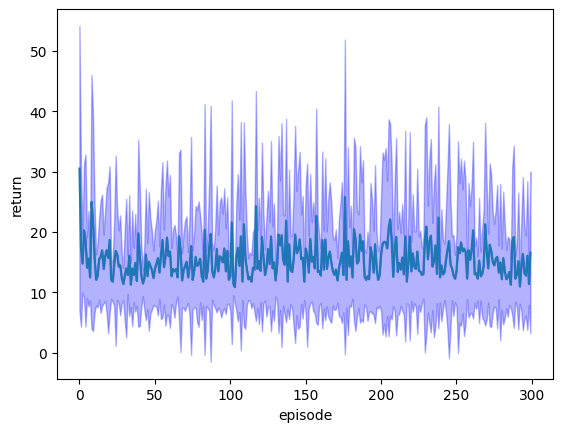

Training with: {'num_runs': 10, 'epsilon_decay': 0.05, 'learning_rate': 0.1, 'replay_buffer_size': 20000, 'batch_size': 64, 'update_frequency': 5, 'loss_function': 'MSE', 'network_architecture': (4, 64, 64, 2)}
Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10


In [ ]:
import random

hyper_parameter_space = {
    "num_runs": [10],
    "epsilon_decay": [0.05],
    "learning_rate": [0.1, 0.5, 1],
    "replay_buffer_size": [10000, 20000],
    "batch_size": [32, 64],
    "update_frequency": [5, 10],
    "loss_function": ["MSE"],
    "network_architecture": [[4, 64, 64, 2]]
}

def generate_random_configuration(hyper_parameter_space):
    configuration = {
        'num_runs': random.choice(hyper_parameter_space['num_runs']),
        'epsilon_decay': random.choice(hyper_parameter_space['epsilon_decay']),
        'learning_rate': random.choice(hyper_parameter_space['learning_rate']),
        'replay_buffer_size': random.choice(hyper_parameter_space['replay_buffer_size']),
        'batch_size': random.choice(hyper_parameter_space['batch_size']),
        'update_frequency': random.choice(hyper_parameter_space['update_frequency']),
        'loss_function': random.choice(hyper_parameter_space['loss_function']),
        'network_architecture': tuple(random.choice(hyper_parameter_space['network_architecture']))  # Convert to tuple
    }
    return configuration

used_configurations = set()

# runs_results = run_individual({'num_runs': 10,
#                                       'epsilon_decay': 0.01,
#                                       'learning_rate': 0.1,
#                                         'batch_size': 32,
#                                       'replay_buffer_size': 1000,
#                                       'loss_function': "MSE",
#                                                     'update_frequency': 10,
#                                       'network_architecture': [4, 64, 64, 2]})
# plot_chart(runs_results, f"{10}_{0.01}_{0.1}_{32}_{1000}_MSE_{str([4,64,64,2])}.png")


while True:
    configuration = generate_random_configuration(hyper_parameter_space)
    config_key = tuple([configuration[key] if type(configuration[key]) != list else tuple(configuration[key]) for key in configuration])

    if config_key in used_configurations:
        continue

    used_configurations.add(config_key)

    print("Training with:", configuration)

    # Add your training and evaluation code here
    runs_results = run_individual(configuration)
    plot_chart(runs_results, "_".join(map(str, config_key)) + ".png")

    # Insert a break condition as needed


In [ ]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.plot(torch.arange(300), means)
plt.ylabel("return")
plt.xlabel("episode")
plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
plt.show()

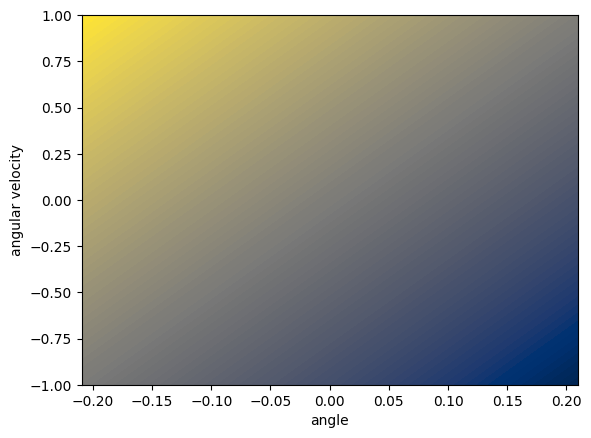

In [6]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 1     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()

# Evolutionary Algorithm for HyperParameter Finetuning

I was planning on using grid-search but this seems a lot more exciting. So i will use this instead

### Fitness function
For my fitness function I'm looking at the average return over the last 50 steps. This will smooth out any outliers and let me know that the model is actually converging.

In [38]:
def calculate_average_returns_and_deviation(results):
    """
    Calculate the average returns and deviation of a DQN model.
    This 
    
    Args:
        results: the results of running the DQN across 10 runs. 

    Returns:
        float: The average reward over the last 50 episodes.
    """
    results = torch.tensor(results)
    means = results.float().mean(0)[:-50].mean()
    stds = results.float().std(0)[:-50].mean()
    
    return float(means), float(stds)


def fitness_score(mean_reward, std_dev, penalty_factor=1.0):
    """
    Calculate the fitness score as the mean reward penalized by a factor of the standard deviation.

    Args:
        mean_reward (float): The average reward over the last 50 episodes.
        std_dev (float): The standard deviation of the rewards over the last 50 episodes.
        penalty_factor (float): The factor by which to multiply the standard deviation before subtracting from the mean.

    Returns:
        float: The calculated fitness score.
    """
    return mean_reward - penalty_factor * std_dev

In [37]:
calculate_average_returns_and_deviation(results)

(22.146400451660156, 10.707107543945312)

22.48

In [34]:
means

tensor(22.1464)

In [44]:
import csv

def mse_loss(policy_dqn, target_dqn, states, actions, rewards, next_states, dones):
    bellman_targets = rewards + 0.99 * (~dones) * target_dqn(next_states).max(1)[0]  # discount factor of 0.99
    current_q_values = policy_dqn(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    loss = F.mse_loss(current_q_values, bellman_targets)
    return loss

def huber_loss(policy_dqn, target_dqn, states, actions, rewards, next_states, dones):
    bellman_targets = rewards + 0.99 * (~dones) * target_dqn(next_states).max(1)[0]  # discount factor of 0.99
    current_q_values = policy_dqn(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
    loss = F.smooth_l1_loss(current_q_values, bellman_targets)
    return loss

class EvolutionaryHyperParameterFineTuner():
    def __init__(self, hyperparameter_space, csv_filename='hyperparameters_results.csv'):
        self.hyper_parameter_space = {
            "num_runs": [10],
            "epsilon_decay": [0.01, 0.05, 0.1, 0.2],
            "learning_rate": [0.1, 0.01, 0.001, 0.0001],
            "replay_buffer_size": [100, 500, 1000, 5000],
            "batch_size": [32, 64, 128, 256],
            "update_frequency": [5, 10, 50, 100],
            "loss_function": ["MSE", "Huber"],
            "network_architecture": [[64, 64], [128, 128], [256, 256], [128, 256, 128]]
        }
        self.csv_filename = csv_filename
        self.initialize_csv()

    def initialize_csv(self):
        with open(self.csv_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Define your CSV columns here
            writer.writerow(['Hyperparameters', 'Reward Mean', 'Standard Deviation'])

    def write_results_to_csv(self, individual, reward_mean, std_mean):
        with open(self.csv_filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([str(individual), reward_mean, std_mean])

    def initialize_population(self, size):
        population = []
        for _ in range(size):
            individual = {param: random.choice(values) for param, values in self.hyper_parameter_space.items()}
            population.append(individual)
        return population
    
    def run_generation(self, population):
        fitness_scores = []
        for individual in population:
            results = self.run_individual(individual)
            mean_reward, std_dev = self.calculate_average_returns_and_deviation(results)
            fitness = self.fitness_score(mean_reward, std_dev)
            fitness_scores.append(fitness)

            self.write_results_to_csv(individual, mean_reward, std_dev)
        return fitness_scores
    
    def evolve_population(self, population, fitness_scores, num_parents, mutation_rate):
        parents = self.select_parents(population, fitness_scores, num_parents)
        next_population = []

        # Crossover to create children
        num_children = len(population) - len(parents)
        for _ in range(num_children):
            parent1, parent2 = random.sample(parents, 2)
            child = self.crossover(parent1, parent2)
            next_population.append(child)

        # Mutation
        for individual in next_population:
            individual = self.mutate(individual, mutation_rate, self.hyper_parameter_space)

        # Adding parents to the next generation
        next_population.extend(parents)

        return next_population
    
    def optimize(self, num_generations, population_size, num_parents, mutation_rate):
        population = self.initialize_population(population_size)

        for generation in range(num_generations):
            print(f"Running generation {generation + 1}")
            fitness_scores = self.run_generation(population)
            population = self.evolve_population(population, fitness_scores, num_parents, mutation_rate)

        # Optionally, return the best individual or the whole final population
        best_individual = population[fitness_scores.index(max(fitness_scores))]
        return best_individual
    
    def calculate_average_returns_and_deviation(self, results):
        """
        Calculate the average returns and deviation of a DQN model.
        This 
        
        Args:
            results: the results of running the DQN across 10 runs. 
    
        Returns:
            float: The average reward over the last 50 episodes.
        """
        results = torch.tensor(results)
        means = results.float().mean(0)[:-50].mean()
        stds = results.float().std(0)[:-50].mean()
    
        return float(means), float(stds)
    
    
    def fitness_score(self, mean_reward, std_dev, penalty_factor=1.0):
        """
        Calculate the fitness score as the mean reward penalized by a factor of the standard deviation.
    
        Args:
            mean_reward (float): The average reward over the last 50 episodes.
            std_dev (float): The standard deviation of the rewards over the last 50 episodes.
            penalty_factor (float): The factor by which to multiply the standard deviation before subtracting from the mean.
    
        Returns:
            float: The calculated fitness score.
        """
        return mean_reward - penalty_factor * std_dev
    
    
    def select_parents(self, population, fitness_scores, num_parents):
        parents = []
        for _ in range(num_parents):
            # Randomly select tournament participants
            tournament = random.sample(list(enumerate(fitness_scores)), k=3)
            # Select the best individual from the tournament
            best_individual = min(tournament, key=lambda x: x[1])[0]
            parents.append(population[best_individual])
        return parents
    
    def crossover(self, parent1, parent2):
        child = {}
        # Determine crossover point
        crossover_point = random.randint(1, len(parent1) - 1)
        for i, key in enumerate(parent1):
            if i < crossover_point:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child
    
    def mutate(self, individual, mutation_rate, hyperparameter_space):
        mutated_individual = individual.copy()
        for key in individual:
            if random.random() < mutation_rate:
                # Randomly select a new value for the hyperparameter
                mutated_individual[key] = random.choice(hyperparameter_space[key])
        return mutated_individual
    
    def run_individual(self, individual):
        # tweak this to run for the variation in hyperparameters
        runs_results = []

        env = gym.make('CartPole-v1')
        for run in range(individual["num_runs"]):
            print(f"Starting run {run+1} of {individual['num_runs']}")
            policy_net = DQN(individual["network_architecture"]) 
            target_net = DQN(individual["network_architecture"])
            update_target(target_net, policy_net)
            target_net.eval()
        
            optimizer = optim.SGD(policy_net.parameters(), lr=individual["learning_rate"])
            memory = ReplayBuffer(individual["replay_buffer_size"])
        
            episode_durations = []
            
            epsilon_start = 1.0
            epsilon_end = 0.01
            epsilon_decay = individual["epsilon_decay"]
            epsilon = epsilon_start
        
            for i_episode in range(300):
                if (i_episode+1) % 50 == 0:
                    print("episode ", i_episode+1, "/", 300)
        
                # Epsilon Decay
                epsilon = epsilon_end + (epsilon_start - epsilon_end) * \
                    math.exp(-1. * i_episode / epsilon_decay)
        
                observation, info = env.reset()
                state = torch.tensor(observation).float()
        
                done = False
                terminated = False
                t = 0
                while not (done or terminated):
        
                    # Select and perform an action
                    action = epsilon_greedy(epsilon, policy_net, state)
        
                    observation, reward, done, terminated, info = env.step(action)
                    reward = torch.tensor([reward])
                    action = torch.tensor([action])
                    next_state = torch.tensor(observation).reshape(-1).float()
        
                    memory.push([state, action, next_state, reward, torch.tensor([done])])
        
                    # Move to the next state
                    state = next_state
        
                    # Perform one step of the optimization (on the policy network)
                    if len(memory.buffer) >= individual["batch_size"]:
                        transitions = memory.sample(individual["batch_size"])
                        state_batch, action_batch, next_state_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
        
                        # Compute loss - assuming loss function is MSE or Huber based on individual setting
                        current_q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(-1)).squeeze(-1)
                        max_next_q_values = target_net(next_state_batch).max(1)[0]
                        expected_q_values = reward_batch + (0.99 * max_next_q_values * (1 - dones)) # discount factor of 0.99
        
                        if individual["loss_function"] == "MSE":
                            loss = mse_loss(policy_net, target_net, state_batch, action_batch, reward_batch, next_state_batch, dones)
                        elif individual["loss_function"] == "Huber":
                            loss = huber_loss(policy_net, target_net, state_batch, action_batch, reward_batch, next_state_batch, dones)

        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                    if done or terminated:
                        episode_durations.append(t + 1)
                    t += 1
                    
                # Update the target network, copying all weights and biases in DQN
                if i_episode % individual["update_frequency"] == 0: 
                    update_target(target_net, policy_net)
            runs_results.append(episode_durations)
        print('Complete')


In [47]:

tuner = EvolutionaryHyperParameterFineTuner({})
tuner.initialize_population(1)

[{'num_runs': 10,
  'epsilon_decay': 0.05,
  'learning_rate': 0.1,
  'replay_buffer_size': 1000,
  'loss_function': 'Huber',
  'network_architecture': [64, 64]}]